# PBMC enrichment for chemokine levels

In [1]:
import pickle
import warnings
import pandas as pd
import networkx as nx
import snp2cell
import scanpy as sc

warnings.simplefilter(action="ignore", category=FutureWarning)

## 1) Load data

Load an anndata object with pbmc single cell expression data from 10x

In [2]:
ad = sc.datasets.pbmc68k_reduced().raw.to_adata()

We are using GWAS summary statistics for circulating CCL2 chemokine levels (GCST004438) as an example.
The full summary statistics has been downloaded from the EBI GWAS catalog and preprocessed into a BED formatted file
with added linkage disequilibrium score (L2):

In [3]:
pd.read_csv("summ_stat_GCST004438_filtered.tsv", sep="\t").head()

,Chromosome,Start,End,Beta,SE,Position,SNP,L2
0,1,1004823,1004823,0.0030,0.0312,1004823,rs35940137,13.834
1,1,1027226,1027226,-0.0056,0.0167,1027226,rs4970393,104.975
2,1,1054900,1054900,-0.0233,0.0169,1054900,rs4275402,65.868
3,1,1055037,1055037,0.0235,0.0169,1055037,rs2465136,66.780
4,1,1082207,1082207,0.0472,0.0187,1082207,rs3766191,53.045


We also create a new snp2cell object. Then we add a gene regulatory network to it, here using an eGRN
computed with Scenic+ from multiome data of immune cells.

In [4]:
s2c = snp2cell.SNP2CELL()

In [5]:
with open("nx_egrn_bone_dev_immune.pkl", "rb") as f:
    G = pickle.load(f)

s2c.add_grn_from_networkx(G)

In [6]:
s2c.save_data("s2c_object.pkl")
# s2c = snp2cell.SNP2CELL("s2c_object.pkl")  # load like this

## 2) Calculate scores

### Calculate scores from the GWAS summary statistics and add them to the snp2cell object.

In [7]:
regions = [n for n in s2c.grn.nodes if n[:3] == "chr"]

snp_scr = snp2cell.util.get_snp_scores(
    regions,
    "summ_stat_GCST004438_filtered.tsv",
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38970/38970 [11:44<00:00, 55.35it/s]


In [8]:
pos2gene = snp2cell.util.get_gene2pos_mapping(rev=True)
snp_scr = {(pos2gene[k] if k in pos2gene else k): v for k, v in snp_scr.items()}

In [9]:
s2c.add_score(snp_scr, score_key="snp_score")
s2c.save_data("s2c_object.pkl")

[INFO - add_score - 2023-10-07 20:35:01,599]: adding score: snp_score
[INFO - add_score - 2023-10-07 20:35:01,635]: propagating score: snp_score
[INFO - add_score - 2023-10-07 20:35:04,149]: storing score snp_score
[INFO - rand_sim - 2023-10-07 20:35:04,180]: ----- starting rand_sim -----
[INFO - rand_sim - 2023-10-07 20:35:04,181]: create 1000 permutations of score snp_score
[INFO - rand_sim - 2023-10-07 20:35:56,833]: propagating permutations
[INFO - loop_parallel - 2023-10-07 20:35:56,839]: using 8 cores
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [23:30<00:00,  1.41s/it]
[INFO - rand_sim - 2023-10-07 20:59:44,874]: storing scores under key snp_score
[INFO - rand_sim - 2023-10-07 21:04:12,553]: ----- finished rand_sim -----
[INFO - add_score_statistics - 2023-10-07 21:04:12,662]: ----- starting add_score_statistics -----


### Calculate DE scores from the single cell data and add them to the snp2cell object.

In [10]:
s2c.link_adata(ad)
s2c.adata_add_de_scores(
    groupby="bulk_labels",
    use_raw=False,
)

[INFO - adata_add_de_scores - 2023-10-07 21:04:51,595]: ----- starting adata_add_de_scores -----
[INFO - adata_add_de_scores - 2023-10-07 21:04:51,616]: finding DE genes for annotation bulk_labels
[INFO - adata_add_de_scores - 2023-10-07 21:04:52,401]: ranking by upregulation...
[INFO - add_score - 2023-10-07 21:04:52,412]: adding score: DE_Dendritic__score
[INFO - add_score - 2023-10-07 21:04:52,947]: adding score: DE_CD14+ Monocyte__score
[INFO - add_score - 2023-10-07 21:04:53,502]: adding score: DE_CD19+ B__score
[INFO - add_score - 2023-10-07 21:04:54,051]: adding score: DE_CD4+/CD25 T Reg__score
[INFO - add_score - 2023-10-07 21:04:54,628]: adding score: DE_CD8+ Cytotoxic T__score
[INFO - add_score - 2023-10-07 21:04:55,197]: adding score: DE_CD56+ NK__score
[INFO - add_score - 2023-10-07 21:04:55,744]: adding score: DE_CD8+/CD45RA+ Naive Cytotoxic__score
[INFO - add_score - 2023-10-07 21:04:56,309]: adding score: DE_CD34+__score
[INFO - add_score - 2023-10-07 21:04:56,864]: addi

### Combine DE scores for each cell type with the GWAS scores.

In [11]:
s2c.adata_combine_de_scores(
    group_key="bulk_labels",
    score_key="snp_score",
    suffix="__zscore",
)
s2c.save_data("s2c_object.pkl")

[INFO - combine_scores - 2023-10-07 21:32:49,159]: ----- starting combine_scores -----
[INFO - combine_scores - 2023-10-07 21:32:49,160]: combining scores: [('DE_Dendritic__score__zscore', 'snp_score__zscore'), ('DE_CD14+ Monocyte__score__zscore', 'snp_score__zscore'), ('DE_CD19+ B__score__zscore', 'snp_score__zscore'), ('DE_CD4+/CD25 T Reg__score__zscore', 'snp_score__zscore'), ('DE_CD8+ Cytotoxic T__score__zscore', 'snp_score__zscore'), ('DE_CD56+ NK__score__zscore', 'snp_score__zscore'), ('DE_CD8+/CD45RA+ Naive Cytotoxic__score__zscore', 'snp_score__zscore'), ('DE_CD34+__score__zscore', 'snp_score__zscore'), ('DE_CD4+/CD45RO+ Memory__score__zscore', 'snp_score__zscore')]
[INFO - combine_scores - 2023-10-07 21:32:49,176]: ----- finished combine_scores -----
[INFO - combine_scores_rand - 2023-10-07 21:32:49,179]: ----- starting combine_scores_rand -----
[INFO - combine_scores_rand - 2023-10-07 21:32:49,180]: combining scores: [('DE_bulk_labels__score', 'snp_score', '__zscore')]
[INFO 

## 3) Plots

### Plot a heatmap of scores.

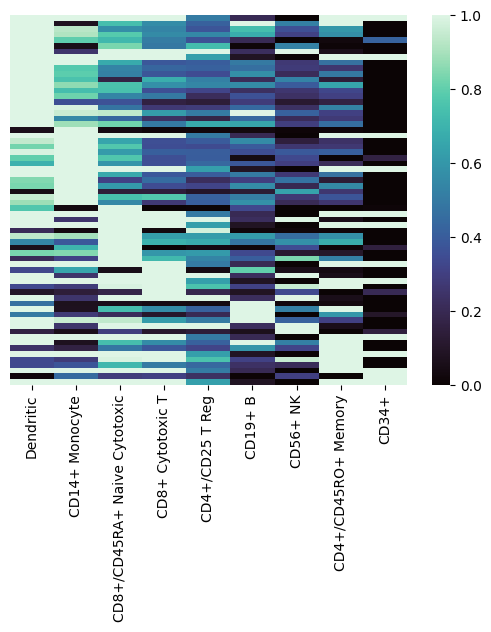

In [12]:
s2c.plot_group_heatmap(
    query="snp_score__FDR < 0.05", regex="min.+snp_score__zscore.*zscore$"
)

### Plot a boxplot of scores.

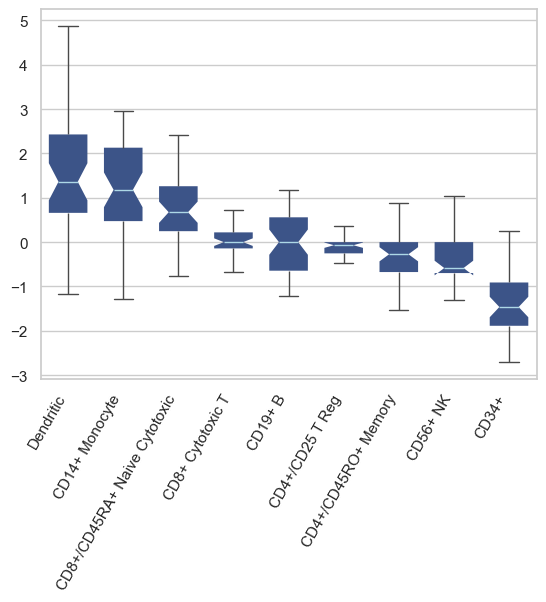

In [13]:
s2c.plot_group_summary(
    query="snp_score__FDR < 0.05", regex="min.+snp_score__zscore.*zscore$"
)

### Plot top genes in dendritic cells.

In [14]:
score_df = s2c.get_scores(
    query="snp_score__FDR < 1.05", regex="min.+snp_score__zscore.*zscore$"
)
score_df = score_df.rename(columns=s2c.rename_column)
score_df = score_df.sort_values("Dendritic", ascending=False)
top_genes = score_df.query("~index.str.startswith('chr')")[:10].index.tolist()

<Axes: >

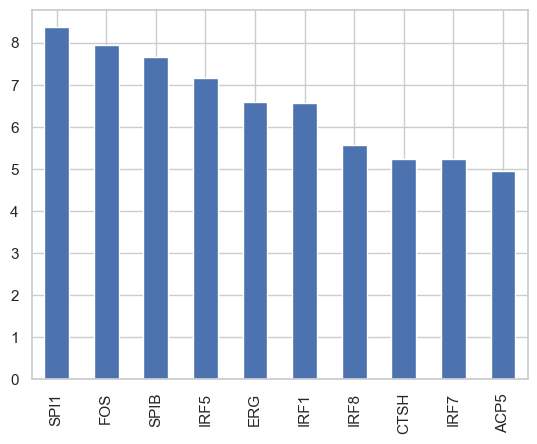

In [15]:
score_df.query("~index.str.startswith('chr')").loc[top_genes, "Dendritic"].plot.bar()

### Plot network of top genes.

In [16]:
top_nodes = score_df.query("index.str.startswith('chr')")[:10].index.tolist()

Gsub, comp = s2c.get_components(
    top_genes + top_nodes + ["CCL2"] + list(s2c.grn.neighbors("CCL2"))
)

[22, 1, 1, 1, 1, 1, 1, 2]


{'FOS': Text(0.1817868984552918, 0.08094445322556575, 'FOS'),
 'IRF5': Text(0.3290107282866866, 0.7531899940710629, 'IRF5'),
 'IRF7': Text(0.026079795407362237, 0.7980549822146641, 'IRF7'),
 'SPI1': Text(0.1889266107472369, 0.367439856296999, 'SPI1'),
 'IRF1': Text(-0.19464323066104816, -0.04134471058993039, 'IRF1'),
 'CTSH': Text(-0.16098653113608383, -0.1169358670826935, 'CTSH'),
 'ERG': Text(-0.0614837056422438, -0.18922910143557367, 'ERG'),
 'CCL2': Text(-0.1181925977490926, -0.4061839939006225, 'CCL2'),
 'IRF8': Text(-0.10091106186240525, 0.025595379117128815, 'IRF8'),
 'ACP5': Text(0.09950327228786995, -0.1723116860230444, 'ACP5'),
 'SPIB': Text(0.21827380825187068, 0.011697189427469, 'SPIB')}

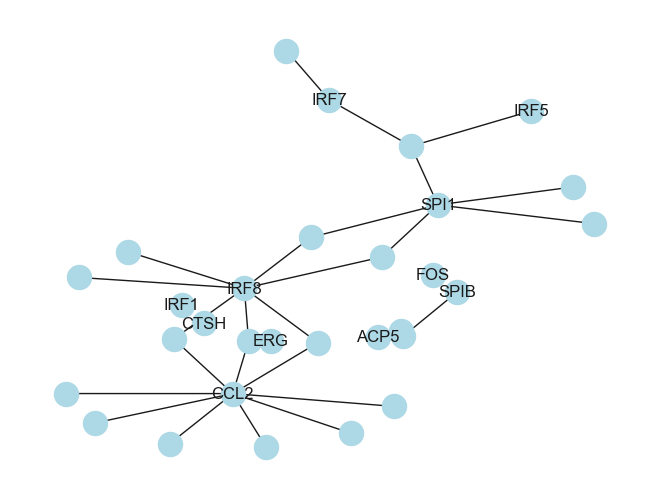

In [17]:
labels = {}
for node in Gsub.nodes():
    if node[:3] != "chr":
        labels[node] = node
pos = nx.kamada_kawai_layout(Gsub)
nx.draw(Gsub, pos, node_color="lightblue")
nx.draw_networkx_labels(Gsub, pos, labels)